## 03 - White Dwarf Radial Velocities
---

Gravitational redshift is a consequence of the theory of general relativity that occurs as photons expend energy climb out of the white dwarf's gravitational potential well. As a result, they are observed at higher wavelengths than when they are emitted. The shift is equal to $\delta\lambda = v_g\lambda_0 / c$, where $\lambda_0$ is the emitted photon's laboratory wavelength, and $v_g$ is the apparent radial velocity of the white dwarf due to the gravitational redshift given by
\begin{equation}
    v_g = \frac{\delta\lambda\cdot c}{\lambda_0} = \frac{GM}{cR}.
\end{equation}

Because $v_g$ is proportional to both mass and radius, it provides one of two independent constraints needed to measure the mass-radius relation of white dwarfs. This, however, is complicated by the fact that white dwarfs generally have non-zero radial velocities and so it is difficult to disentangle the actual radial velocity of the star from the gravitational redshift. Main sequence stars do not undergo appreciable gravitational redshift however, and so their radial velocity is approximately their true radial velocity. Hence by looking at wide binaries of one main sequence companion and one white dwarf, we can measure the gravitational redshift of the white dwarf by subtracting out the observed radial velocity of the main sequence star from the observed radial velocity of the white dwarf.

White dwarf radial velocities were calculated from their spectra using the `corv` python library. `corv` is a tool for calculating the radial velocity of DA white dwarfs. This is done by first coarsely least squares fitting a model atmosphere from KOESTER, ET. AL. using LMFIT with free parameters $\log g$, $T_{eff}$, and $v_r$. This creates a template model atmosphere that serves as a starting point for more accurate assessment of $v_r$. Then, another model atmosphere is fit using Markov Chain Monte Carlo to the spectrum where $\log g$ and $T_{eff}$ are held constant at the values given in the template and only $v_r$ is allowed to vary.

In order to fit $v_r$, the spectrum is cropped around each line in the Balmer series $\alpha$ through $\delta$ in windows of $100$ angstrom for lines $\alpha$ and $\beta$, $85$ angstrom for the $\gamma$ line, and $75$ angstrom for the $\delta$ line. **Talk about why these windows were chosen.** Then, Voight profiles are fit to all emission lines simultaneously. This is preferable to independently fitting each line because fitting simultaneously takes advantage of the constant spacing between emission lines to get a more accurate radial velocity measurement.

In [1]:
#from sklearn.cluster import KMeans
import numpy as np
import scipy as sp
import sys
sys.path.append('../corv/src')
sys.path.append('../wdtools')

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from astropy.io import fits
from astropy.table import Table
from tqdm import tqdm
import pandas as pd
#import corv

### Query
from astroquery.sdss import SDSS
from astroquery.gaia import Gaia
from astropy import constants as c
import data_selector as ds

#import wdtools
import corv


E:\corv\models/
using local paths
star and exposure catalogs not found! check paths and run make_catalogs() if you want to use sdss functionality. otherwise ignore.


In [2]:
#d1 = pd.read_csv('data/wd_spectra.csv')
#d1 = Table.from_pandas(d1)

catalog = Table.read('data/00_raw.fits')
print(len(catalog))

alldat = catalog.copy()

4490


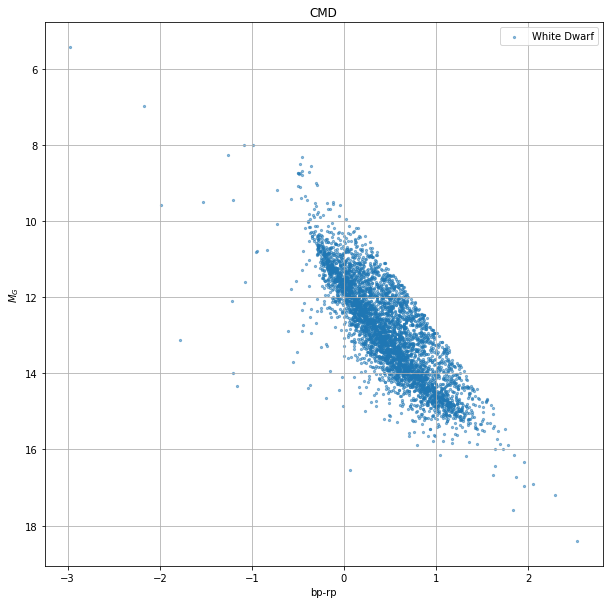

In [3]:
plt.figure(figsize=(10,10))

plt.scatter(catalog['wd_bp_rp'], catalog['wd_m_g'], label='White Dwarf', alpha = 0.5, s=5)

plt.grid()
plt.ylabel(r'$M_G$')
plt.xlabel(r'bp-rp')
plt.title(r'CMD')
plt.gca().invert_yaxis()
xmin, xmax = plt.xlim()

plt.legend()
plt.show()

In [4]:
'''
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.table import Table, join_skycoord
from astropy import table

print(spAll.keys())

print(spAll[['RACAT', 'DECCAT']])

spAll = spAll[spAll['DECCAT'] < 90]
spAll = spAll[spAll['DECCAT'] > -90]

catalog['wd_pos'] = SkyCoord(catalog['wd_ra'], catalog['wd_dec'], unit='deg')
spAll['wd_pos'] = SkyCoord(spAll['RACAT'], spAll['DECCAT'], unit='deg')

join_func = table.join_skycoord(5 * u.arcsecond)
sdss5_catalog = table.join(catalog, spAll, join_funcs={'wd_pos': join_skycoord(5 * u.arcsec)})
'''

"\nfrom astropy.coordinates import SkyCoord\nimport astropy.units as u\nfrom astropy.table import Table, join_skycoord\nfrom astropy import table\n\nprint(spAll.keys())\n\nprint(spAll[['RACAT', 'DECCAT']])\n\nspAll = spAll[spAll['DECCAT'] < 90]\nspAll = spAll[spAll['DECCAT'] > -90]\n\ncatalog['wd_pos'] = SkyCoord(catalog['wd_ra'], catalog['wd_dec'], unit='deg')\nspAll['wd_pos'] = SkyCoord(spAll['RACAT'], spAll['DECCAT'], unit='deg')\n\njoin_func = table.join_skycoord(5 * u.arcsecond)\nsdss5_catalog = table.join(catalog, spAll, join_funcs={'wd_pos': join_skycoord(5 * u.arcsec)})\n"

In [5]:
#print(sdss5_catalog[['wd_pos_id', 'wd_pos_1', 'wd_pos_2']])

In [6]:
ADQL_CODE1 = "SELECT \
        sdss.original_ext_source_id as bestobjid,\
        gaia_source.source_id\
        FROM gaiaedr3.gaia_source \
        JOIN gaiaedr3.sdssdr13_best_neighbour as sdss\
        ON gaia_source.source_id = sdss.source_id      \
        WHERE gaia_source.source_id IN {}\
    ".format(tuple(catalog['wd_source_id']))

job1 = Gaia.launch_job(ADQL_CODE1,dump_to_file=False)
d1 = job1.get_results()
print(len(d1))

1108


In [7]:
drops = []
bestobjid1 = []

for i in tqdm (range(len(catalog))):
    notfound = False
    a = np.where(d1['source_id'] == catalog['wd_source_id'][i])
    
    try:
        j = a[0][0]
    except:
        notfound = True
        
    if not notfound: 
        try:
            bestobjid1.append(d1['bestobjid'][j])
        except:
            notfound = True
    if notfound:
        drops.append(i)    
        
catalog.remove_rows(drops)
catalog['wd_bestobjid'] = bestobjid1

100%|████████████████████████████████████████████████████████████████████████████| 4490/4490 [00:00<00:00, 9125.83it/s]


In [8]:
print(catalog['wd_bestobjid'])

plt.figure(figsize=(10,10))

plt.scatter(alldat['wd_bp_rp'], alldat['wd_m_g'], label='White Dwarf', alpha = 0.5, s=5)
plt.scatter(catalog['wd_bp_rp'], catalog['wd_m_g'], label='Kept Stars', alpha = 1, s=15)

plt.grid()
plt.ylabel(r'$M_G$')
plt.xlabel(r'bp-rp')
plt.title(r'CMD')
plt.gca().invert_yaxis()
xmin, xmax = plt.xlim()

plt.legend()
plt.show()

    wd_bestobjid   
-------------------
1237667136955416672
1237666464265994487
1237667207828799608
1237668658989761033
1237667205679677575
1237679477466661011
1237672764441952307
1237672763904753827
1237680275256049763
1237678542236483670
                ...
1237662530607644949
1237668311090593860
1237668336321495175
1237665547825185381
1237667782320324692
1237665566081679524
1237667735599841356
1237667782856147342
1237658220601934186
1237658187854053542
1237663787955978273
Length = 1108 rows


KeyboardInterrupt: 

<Figure size 720x720 with 0 Axes>

In [ ]:
from astropy.table import Table, vstack, hstack

stardats = []
iters = len(catalog) // 100

for i in tqdm(range(iters)):
    SDSS_QUERY = """select bestObjID, plate, mjd, fiberID, subClass
        from dbo.SpecObjAll
        where bestObjID in {}""".format(tuple(catalog['wd_bestobjid'][100*i:100*i+100]))
    
    stardats.append(SDSS.query_sql(SDSS_QUERY))
spec = vstack(stardats)


In [ ]:
print(spec)


In [ ]:

drops = []
plate = []
mjd = []
fiber = []
types = []

for i in tqdm (range(len(catalog))):
    notfound = False
    a = np.where(spec['bestObjID'] == catalog['wd_bestobjid'][i])
    
    try:
        j = a[0][0]
    except:
        notfound = True
        
    if not notfound: 
        try:
            
            plate.append(spec['plate'][j])
            mjd.append(spec['mjd'][j])
            fiber.append(spec['fiberID'][j])
            types.append(spec['subClass'][j])
            
            
        except:
            notfound = True
    if notfound:
        drops.append(i)    
        
catalog.remove_rows(drops)
catalog['plate'] = plate
catalog['mjd'] = mjd
catalog['fiber'] = fiber
catalog['subClass'] = types


In [ ]:
#sample = Table.read('data/verification/corvcat_cannon.fits', format='fits')
#catalog_raw = Table.read('data/00_raw.fits')

#print(sample.keys())

In [ ]:
#stardats = []
#iters = len(sample) // 100

#for i in tqdm(range(iters)):
#    ADQL_CODE1 = "SELECT \
#        bp_rp, phot_g_mean_mag, parallax\
#        FROM gaiadr2.gaia_source \
#        WHERE gaia_source.source_id IN {}\
#    ".format(tuple(sample['dr2_id'][100*i:100*i+100]))
    
#    stardats.append(Gaia.launch_job(ADQL_CODE1,dump_to_file=False).get_results())
#spec = vstack(stardats)


In [ ]:
#spec['m_g'] = spec['phot_g_mean_mag'] + 5 * (np.log10(spec['parallax'] / 100))

In [ ]:
#plt.figure(figsize=(10,10))

#plt.scatter(spec['bp_rp'], spec['m_g'], label='SDSS-V Stars', alpha = 0.5, s=5)
#plt.scatter(alldat['wd_bp_rp'], alldat['wd_m_g'], label='White Dwarf', alpha = 0.5, s=5)
#plt.scatter(catalog['wd_bp_rp'], catalog['wd_m_g'], label='Kept Stars', alpha = 1, s=15)

#plt.grid()
#plt.ylabel(r'$M_G$')
#plt.xlabel(r'bp-rp')
#plt.title(r'CMD')
#plt.gca().invert_yaxis()
#xmin, xmax = plt.xlim()

#plt.legend()
#plt.show()

In [ ]:
#catalog_raw['dr2_id'] = catalog_raw['wd_source_id']

#print(sample[sample['dr2_id'] == 513557971255935744])

In [ ]:
#from astropy.table import Table, Column, MaskedColumn, join, unique
#
#re_catalog = join(sample, catalog_raw, keys='dr2_id')
#re_catalog = unique(re_catalog, keys='dr2_id')
#print(re_catalog)
#
#plt.figure(figsize=(10,10))
#
##plt.scatter(spec['bp_rp'], spec['m_g'], label='SDSS-V Stars', alpha = 0.5, s=5)
##plt.scatter(alldat['wd_bp_rp'], alldat['wd_m_g'], label='White Dwarf', alpha = 0.5, s=5)
#plt.scatter(re_catalog['wd_bp_rp'], re_catalog['wd_m_g'], label='SDSS-V Stars', alpha = 1, s=15)
#plt.scatter(catalog['wd_bp_rp'], catalog['wd_m_g'], label='SDSS-IV Stars', alpha = 1, s=15)
#
#
#
#plt.grid()
#plt.ylabel(r'$M_G$')
#plt.xlabel(r'bp-rp')
#plt.title(r'CMD')
#plt.gca().invert_yaxis()
#xmin, xmax = plt.xlim()
#
#plt.legend()
#plt.show()

In [ ]:
spec = []
wl = []
fl = []
ivar = []
drops = []
worked = []

for i in tqdm(range(len(catalog))):
    try:
        spec = SDSS.get_spectra_async(plate=plate[i], fiberID=fiber[i], mjd=mjd[i])[0].get_fits()
        
        #print(spec[4].header)
        
        wl.append(10**spec[1].data['loglam'])
        fl.append(spec[1].data['flux'])
        ivar.append(spec[1].data['ivar'])
        worked.append(i)
    except:
        drops.append(i)
        
print(len(wl))
print(len(fl))
print(len(ivar))
        
catalog.remove_rows(drops)
catalog['wd_wl'] = wl
catalog['wd_fl'] = fl
catalog['wd_ivar'] = ivar

In [ ]:
print(catalog['subClass'])

print(len(catalog))

In [ ]:
def pseudonormalize(fl, win = 250):
    cont_fl = np.repeat(np.nan, len(fl))
    
    for i in range(len(fl)):
        if (i - (win / 2)) < 0:
            fl_win = fl[0:(i + (win // 2))]
        else:
            fl_win = fl[(i - (win // 2)) : (i + (win // 2))]
        
        cont_fl[i] = np.percentile(fl_win, 90)
        
    return fl / cont_fl
'''
def spec_split(bands, wl, fl, window_size = 100):
    spec_split = {}
    
    for i in range(len(bands)):
        spec_split[bands.keys()[i]] = np.array([ [wl[
'''

In [ ]:
id_ = []
balmer_lines = [6562.79, 4861.35, 4340.47, 4101.73, 3970.07, 3889.06, 3835.40]

for i in tqdm(range(len(catalog))):
    id_.append(i)

    plt.figure(figsize=(30,12))
    
    plt.subplot(2,2,1)
    plt.plot(catalog['wd_wl'][i], catalog['wd_fl'][i])
    min_, max_ = plt.ylim()
    plt.vlines(balmer_lines, min_, max_, colors = 'black', linestyle = 'dashed', alpha = 0.5)
    plt.grid()
    plt.ylabel(r'Flux [$10^{-17}$ ergs/s/cm2/A]')
    plt.xlabel(r'Wavelength [A]')
    plt.title('White Dwarf Spectrum {}'.format(i))
    
    plt.subplot(2,2,3)
    plt.plot(catalog['wd_wl'][i], pseudonormalize(catalog['wd_fl'][i]))
    min_, max_ = plt.ylim()
    plt.vlines(balmer_lines, min_, max_, colors = 'black', linestyle = 'dashed', alpha = 0.5)
    plt.grid()
    plt.ylabel(r'Flux [$10^{-17}$ ergs/s/cm2/A]')
    plt.xlabel(r'Wavelength [A]')
    #plt.title('White Dwarf Spectrum {}'.format(i))
    plt.savefig('spectra/sdss4/wd{}.png'.format(i))

    
catalog['wd_catalog_id'] = id_

In [ ]:
print(i)
nwl = catalog['wd_wl'][i]
nfl = catalog['wd_fl'][i]
cont = pseudonormalize(nfl, 250)

plt.figure(figsize=(20,8))

plt.plot(nwl, cont)
plt.grid()
plt.ylabel(r'Normalized Flux')
plt.xlabel(r'Wavelength [A]')
plt.title('Normalized Spectrum')
ax = plt.gca()

plt.show()

In [ ]:
not_da = np.array([0,1,4,5,9,13,15,20,21,23,26,28,30,32,33,34,35,46,48,50,52,54,55,61,63,64,65,
                  66,68,69,70,72,75,79,81,84,87,89,90,93,96,97,98,100,101,102,103,109,111,112,113,116])
reject = catalog[not_da]

catalog.remove_rows(not_da)

print([np.any(np.isnan(catalog['wd_ivar'][i])) for i in range(len(catalog))])

In [ ]:
from astropy.table import Table, Column, MaskedColumn, join


teff_prior = True

try:
    nug = Table.read('data/nug.fits')
    print(catalog['wd_source_id'])
    catalog = join(catalog, nug, keys='wd_source_id', join_type='inner')
    print('worked')
except:
    teff_prior = False

In [ ]:
from lmfit import Parameters, fit_report, minimize

calculate_rvs = True


if calculate_rvs:
    rvs = []
    e_rvs = []
    
    catalog['rv_id'] = np.ones(len(catalog))

    teff = []
    logg = []
    e_teff = []
    e_logg = []

    redchi = []
    drops = []
    figs = []

    return_obj = []

    #catalog['wd_ivar'] = [catalog['wd_ivar'][i]  for i in range(len(catalog))]

    for i in tqdm(range(len(catalog))):
        print(catalog['phot_teff'][i])
        corvmodel = corv.models.make_koester_model(names = ['a','b','g','d'])

        fl = np.array(catalog['wd_fl'][i])

        #for j in range(len(fl)):
        #    if fl[j] < 0:
        #        fl[j] = 0

        param_res, rv_res, rv_init = corv.fit.fit_corv(np.array(catalog['wd_wl'][i]), fl, np.array(catalog['wd_ivar'][i]), corvmodel, teff = catalog['phot_teff'][i])

        if rv_res.params['teff'].stderr == None:
            rv_res.params['teff'].stderr = 1e-6
        if rv_res.params['logg'].stderr == None:
            rv_res.params['logg'].stderr = 1e-6
        if rv_res.params['RV'].stderr == None:
            rv_res.params['RV'].stderr = 1e-6

        f = corv.utils.lineplot(np.array(catalog['wd_wl'][i]), np.array(catalog['wd_fl'][i]), np.array(catalog['wd_ivar'][i]), corvmodel, rv_res.params, gap = 0.3, printparams = True,
                 figsize = (6, 5))

        f.suptitle('%d : %2.2f +/- %2.2f' % (catalog['wd_catalog_id'][i], rv_res.params['RV'].value, rv_res.params['RV'].stderr))
        figs.append(f)

        #f.savefig('spectra/corvfits/corvfit{}.jpg'.format(i))

        teff.append(rv_res.params['teff'].value)
        logg.append(rv_res.params['logg'].value)
        e_teff.append(rv_res.params['teff'].stderr)
        e_logg.append(rv_res.params['logg'].stderr)

        rvs.append(rv_res.params['RV'].value)
        e_rvs.append(rv_res.params['RV'].stderr)
        redchi.append(rv_res.redchi)

        return_obj.append(rv_res)
        
        catalog['rv_id'][i] = i



    #catalog.remove_rows(drops)
    catalog['rv'] = rvs
    catalog['e_rv'] = e_rvs

    catalog['corv_logg'] = logg
    catalog['corv_teff'] = teff
    catalog['e_teff'] = e_teff
    catalog['e_logg'] = e_logg
    
    catalog['e_rv'][catalog['e_rv'] == None] = 1e-6
    catalog['rechi'] = redchi
    catalog['figs'] = figs
    
else:
    rv_cat = Table.read('data/wd_rvs.fits')
    
    catalog['rv'] = rv_cat['rv']
    catalog['e_rv'] = rv_cat['e_rv']

In [ ]:
print(len(catalog))
#print(len(rvs))
#catalog = catalog[catalog['rechi'] < 2.5]
#catalog = catalog[(catalog['rv'] / catalog['e_rv']) > 5]
#catalog = catalog[catalog['rv'] < 1000]

if calculate_rvs:
    for i in range(len(catalog)):
        catalog['figs'][i].savefig('spectra/corvfits/corvfit{}.jpg'.format(catalog['wd_catalog_id'][i]))
        
    catalog.remove_columns(['figs'])
    

In [ ]:
#catalog[['e_rv', 'e_logg', 'e_teff']].pprint(max_lines=-1)

In [ ]:
catalog['e_rv'] = np.array(catalog['e_rv']).astype(float)

In [ ]:
'''

plt.figure(figsize=(25,16))


has_erv = []
for i in range(len(catalog)):
    if catalog['e_rv'][i] > 1e-4:
        has_erv.append([i, np.mean(catalog['wd_ivar'][i])])
        
has_erv = np.array(has_erv).T

num = np.array([i for i in range(len(catalog))])
mean_ivar = np.array([np.mean(catalog['wd_ivar'][i]) for i in range(len(catalog))])

'''
#===============================================
#                Plot One
#===============================================
'''

i = [0,5]

plt.subplot(3,2,1)
plt.scatter(num, mean_ivar, label = 'No Error Reported')
plt.scatter(has_erv[0], has_erv[1], label = 'Error Reported')

#plt.hlines(1, 0, 40)
plt.grid()
plt.ylabel(r'Mean ivar')
plt.xlabel(r'Spectrum Number')
#plt.title('White Dwarf Spectrum')
plt.legend()

plt.subplot(3,2,2)

plt.scatter(num, mean_ivar, label = 'No Error Reported')
plt.scatter(has_erv[0], has_erv[1], label = 'Error Reported')

#plt.hlines(1, 0, 40)
plt.grid()
plt.ylabel(r'Mean ivar')
plt.xlabel(r'Spectrum Number')
plt.legend()

'''
#===============================================
#    Plot Two
#===============================================
'''

plt.subplot(3,2,3)

plt.plot(catalog['wd_wl'][i[0]], catalog['wd_fl'][i[0]])
plt.text(0.05, 0.14, 'Redchi: {}'.format(round(catalog['rechi'][i[0]], 3)), fontsize=12,
                transform = plt.gca().transAxes)

plt.grid()
plt.ylabel(r'ivar')
plt.xlabel(r'Wavelength')
plt.title('Spectrum Number {} (No Error Reported)'.format(i[0]))

plt.subplot(3,2,4)
color = plt.cm.coolwarm(catalog['wd_ivar'][i[0]])
plt.scatter(catalog['wd_wl'][i[0]], catalog['wd_fl'][i[0]], c=catalog['wd_ivar'][i[0]], cmap = 'coolwarm', s=10)

plt.grid()
plt.ylabel(r'Flux')
plt.xlabel(r'Wavelength')
plt.title('Spectrum Number {} (No Error Reported)'.format(i[0]))
plt.colorbar(label='ivar')

'''
#===============================================
#    Plot Three
#===============================================
'''

plt.subplot(3,2,5)

plt.plot(catalog['wd_wl'][i[1]], catalog['wd_fl'][i[1]])
plt.text(0.05, 0.14, 'Redchi: {}'.format(round(catalog['rechi'][i[1]], 3)), fontsize=12,
                transform = plt.gca().transAxes)


plt.grid()
plt.ylabel(r'ivar')
plt.xlabel(r'Wavelength')
plt.title('Spectrum Number {} (Error Reported)'.format(i[1]))

plt.subplot(3,2,6)
#color = plt.cm.coolwarm(catalog['wd_ivar'][i])
plt.scatter(catalog['wd_wl'][i[1]], catalog['wd_fl'][i[1]], c=catalog['wd_ivar'][i[1]], cmap = 'coolwarm', s=10)

plt.grid()
plt.ylabel(r'Flux')
plt.xlabel(r'Wavelength')
plt.title('Spectrum Number {} (Error Reported)'.format(i[1]))
plt.legend()
plt.colorbar(label='ivar')


plt.show()

'''

In [ ]:
print(catalog[['rv','e_rv']])

'''
bad_corv = np.array([37, 38])
bad_corv = np.array([3, 5, 10, 23, 26, 27, 31, 37, 38, 39, 42, 43])
catalog.remove_rows(bad_corv)
'''

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 9))
#axes.grid()
axes.hist(catalog['ms_rv'], bins = 15, alpha=0.5, color='black', label='Main sequence')
#axes.hist(catalog['rv'], bins = 15, alpha=0.5, color='red', label='White dwarf')
ymin, ymax = axes.get_ylim()
axes.vlines(np.mean(catalog['ms_rv']), ymin, ymax, linestyles='dashed')
#axes.vlines(np.mean(catalog['rv']), ymin, ymax, linestyles='dashed', color='red')

#axes[0].set_title('Gravitational Redshift', fontsize=20)
axes.set_xlabel(r'$RV [km/s]$', fontsize=18)
axes.legend()

In [ ]:
catalog['g_redshift'] = catalog['rv'] - catalog['ms_rv']
catalog['eg_redshift'] = catalog['ms_erv'] + catalog['e_rv']

#catalog = catalog[catalog['g_redshift'] > -100]
#catalog = catalog[catalog['g_redshift'] < 100]

print(np.mean(catalog['g_redshift']))
print(len(catalog))


plt.figure(figsize=(10,10))
plt.grid()
plt.hist(catalog['g_redshift'], bins = 20, histtype='step', color='black')
ymin, ymax = plt.ylim()
plt.vlines(np.mean(catalog['g_redshift']), ymin, ymax, linestyles='dashed')
plt.title('Gravitational Redshift', fontsize=20)
plt.xlabel(r'$RV_{MS} - RV_{WD}$', fontsize=18)

In [ ]:
for col in catalog.columns:
    if catalog[col].dtype == object: print(col)

In [ ]:
#catalog.remove_columns(['wd_wl', 'wd_fl', 'wd_ivar'])
#catalog.write('data/03_wd_rv.fits', format='fits', overwrite=True)